# Homework 2: Topic Modeling of COVID-19 Tweets Over Time

In this homework, you will be using topic modeling to identify topics in tweets about COVID-19 collected from February through April. You will use PCA to visualize the results of your topic modeling as well as investigate the semantic meaning of the topics you have found and the prevalence of these topics over time. To complete this homework assignment, run each block of code, filling in code as needed. 

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading Tweet Data

In [110]:
tweets = pd.read_csv('april_data.csv')

In [111]:
tweets.head()

,Unnamed: 0,date,text
0,0,2020-04-05 23:59:34,PROMISING NEWS! We asked a local doctor about ...
1,1,2020-04-05 23:59:11,ToP 10 #LightsOverLockdown Videos That could A...
2,2,2020-04-05 23:59:01,#MakeChinaPay China owes us all. #Covid_19 #Ch...
3,3,2020-04-05 23:58:34,#Hydroxycloroquine shows promising results in ...
4,4,2020-04-05 23:58:29,Yes and their numbers are going down!


# Topic Modeling

## Building Our Model

To do our topic modeling, we will be using Latent Dirichlet Allocation to do topic modeling, which you learned about in lecture. Don't worry, we will not be implementing Latent Dirichlet Allocation, instead we will be using the tools already available to us (sklearn) in order to do topic modeling.  For a refresher on this method, you can check out [this](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158) blog post. To start we will build up some understanding of how to use sklearn's LDA functionality. 

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
lda = LatentDirichletAllocation(n_components = 10, random_state = 0)

We will start out by adding to our stop words. These are words that may be repeated often in the tweets, but do not add any topic information. These are words like 'the', 'a', 'that', 'almost', 'every', etc. You can check out the existing stop words using text.ENGLISH_STOP_WORDS if you want to know what's included. What you need to do is add words that are likely not in the existing stop word list that will not add any information to our topics. Because all the tweets are already about COVID-19, words used to identify the virus are likely not helpful, nor are things like 'https' and 'com' from links. Think about what words might come up a lot but do not differentiate tweets and add them to the stop list. After you run the topic modeling and see the words in the topics, continue to add unimportant words to the stop list to refine your topics (we added about 15 additional stop words but you can add as many as you think are appropriate). 

## TASK 1: add stop words

In [142]:
my_stops = text.ENGLISH_STOP_WORDS.union(
    
    ['COVID19', 'the', 'a', 'everyday','deaths','cases','thank','country','trump','covid_19','coronavirus','amp','https','covid','19','death','people']

)

Next, we will vectorize the tweets. This makes it so each tweet is represented by an w-dimensional vector, where w is the total number number of unique words in all the tweets (not including the stop words). 

In [143]:
vectorizer = CountVectorizer(min_df=10, stop_words=my_stops)
counts = vectorizer.fit_transform(tweets.text)

Now we will run Latent Dirichlet Allocation to find our topics. Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) in order to understand all of the parameters. 

In [115]:
as_topics = LatentDirichletAllocation(n_components=8, random_state=0, n_jobs=6).fit(counts)

In [116]:
def print_topics(topics,vectorizer):
    """
    Prints top 12 most important words for each topic in descending importance
    """
    topic_dists = (topics.components_.T / topics.components_.sum(axis=1)).T
    for comp in range(len(topic_dists)):
        top_i = np.argsort(topic_dists[comp])[-12:][::-1]
        print()
        print([key for key, value in vectorizer.vocabulary_.items() if value in top_i])

In [117]:
print_topics(as_topics, vectorizer)


['patients', 'hospital', 'new', 'tests', 'positive', '000', 'symptoms', 'covid19', 'uk', 'week', 'confirmed', 'city']

['time', 'corona', 'home', 'like', 'virus', 'force', 'fight', 'thanks', 'fuck', 'day', 'having', 'india']

['news', 'corona', 'just', 'virus', 'pic', 'twitter', 'com', 'www', '2020', '04', '5g', 'man']

['patients', 'china', 'home', 'care', 'ago', 'work', 'pandemic', 'covid19', 'health', 'weeks', 'stay', 'help']

['president', 'says', 'new', 'pandemic', 'dr', 'states', 'http', 'fauci', 'let', 'medical', 'today', 'west']

['world', 'crisis', 'like', 'government', 'social', 'pandemic', 'away', 'health', 'lives', 'food', 'family', 'queen']

['news', '12', 'going', 'tests', 'just', 'need', 'died', 'great', 'really', 'vaccine', 'breaking', 'testing']

['corona', 've', 'tiger', 'bronx', 'zoo', 'positive', 'tested', 'virus', 'test', 'got', 'person', 'ik_saviourofnation']


## Evaluating our Model

This is an unsupervised learning technique meant to help us find structure in our data. The data will always be divided into topics, however that does not mean that the topics will have meaning. This makes the qualitative part of topic modeling very important because you need to be able to look at the topics generated above and understand whether the model seems to have captured true structure or just noise. Now we can think about ways to visualize what we have just created. 

One way we can gain intuition about our model is by checking how strongly it is classifying tweets into one category or another. In other words, how sure the model is of the topic of a tweet. When predicting the topic for a tweet, the trained model returns a distribution over the possible topics, which is referred to as that tweet in _topic space_. For example, if we had three topics it would return a vector of length 3 with the 3 values summing to 1. The topic represented by the highest probability is the principal topic of that tweet. The higher that maximum value is compared to the other probabilities, the stronger the association of that tweet to its principal topic. If tweets tend to have strong principal topics, then there is a lot of structure in the topic space of the tweets and the topics are more likely to be useful.

By measuring this charactaristic of our model, we are making sure our model identified more general structure in the tweets and didn't train strictly on noise. While this doesn't mean that the topics have __meaning__, it is a check that there is clustering going on. To visualize whether this clustering is happening we can plot our points and color them based on their given topic. However, our data is more than 3-dimensions, making it difficult to visualize. That's where dimensionality reduction techniques come in. There are many techniques out there, but we are going to focus on PCA as it is ubiquitous, easy to understand, and very useful. 

If you want to explore other demonsionality reduction tools, [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is a widely used one as well. 

## TASK 2: Implement PCA

Before we perform PCA to visualize our topic modeling, check out [this](https://datascienceplus.com/understanding-the-covariance-matrix/) blog post on covariance matrices and [this](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) blog post on PCA if you are unfamiliar with either topic. To really solidify your understanding of PCA, you are going to __implement it yourself__.

To do this, please fill in the provided helper functions and PCA wrapper function. You __may not__ use any built in PCA functions but you can use anything else. The following example depends on your implementation of this code so make sure to implement it before running that. 



In [118]:
def get_covariance(data):
    """
    Given a matrix of data, returns covariance matrix
    
    Hint: Make sure to standardize your data and center it around zero. 
    Try to do this in a vectorized manner, our solution was less than 5 lines. 
    """
    # Your code here
    
    Center = data - np.mean(data, 0)
    standard = Center/np.std(Center, 0)
    covariance = np.dot(standard, standard.transpose())/np.size(data, axis = 1)
    
    return covariance

In [119]:
def pca(data):
    """
    Given a matrix of data, returns sorted eigenvalues and eigenvectors of covariance matrix
    
    Hint: This function should use your get_covariance() function and you might find np.linalg.eig() 
            and np.argsort() helpful
    
    """
    
    # Your code here
    
    X = get_covariance(data)
    
    eigen_vals, eigen_vecs = np.linalg.eig(X)
        
    sort = np.argsort(eigen_vals)[::-1]
    eigen_vals = eigen_vals[sort]
    eigen_vecs = eigen_vecs[:,sort] 
    
    return eigen_vals, eigen_vecs

In [120]:
def pca_transform(data, num_dims = 2):
    """
    Given a matrix of data, returns data projected onto num_dims principal components (use your pca() function)

    """
    # Your code here
    #Center = data - np.mean(data,0)
    #standard = Center/np.std(Center, 0)
    
    cov = get_covariance(data)
    transformed_data = np.dot(cov, pca(data)[1])
    
    return transformed_data

In [121]:
pca_transform(u, num_dims = 2)

array([[-1.85626701e+00, -1.69209241e-01,  6.42461068e-18],
       [ 1.61219962e+00, -2.59767279e-01,  1.32815783e-16],
       [ 2.44067385e-01,  4.28976521e-01, -4.82489523e-17]])

In [122]:
def plot_pca(data, graph_title='Transformed Data'):
    """
    Given a matrix of data, runs PCA and plots transformed data onto first 2 principal components
    
    """
    labels = np.argmax(data, axis=1)
    reduced_data = pca_transform(data)

    scatter = plt.scatter(reduced_data[:,0], reduced_data[:,1], c = labels)
    plt.legend(*scatter.legend_elements())
    plt.title(graph_title)
    plt.show()

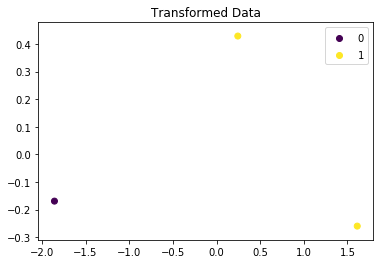

In [123]:
plot_pca(u, graph_title='Transformed Data')

## Using Principal Components Analysis to visualize structure

Now that we have our PCA up and running, we can gain some intuition on what our results might be showing us. From our visualization, we want to be able to determine if tweets are grouped tightly around a series of distinct topics (structured) or if tweets are not clearly defined by any one topic (unstructured).

When we do LDA topic modeling, we are assuming that tweets are the results of samples from an underlying dirichlet distribution. Therefore we can make data that "looks" structured or unstructured by sampling from a corresponding Dirichlet distribution. In the structured data visualization we are sampling from a distribution with a high likelihood of a (1.0,0,0,...,0) distribution, (or some permutation of that result), and in the unstructured data visualization we are sampling from a distribution with a high probability of a uniform vector.

__NOTE:__ If you are getting an error with the plotting function, try updating matplotlib using the command ```pip install --upgrade matplotlib``` in your command line. Restart your notebook before trying again. 

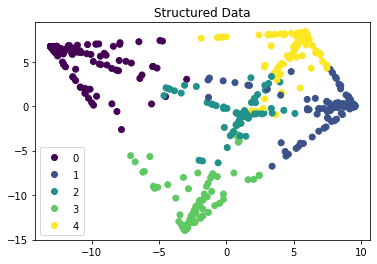

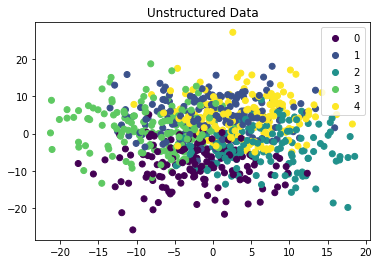

In [124]:
structured_data = np.random.dirichlet(np.ones(5)*.05, 800)
unstructured_data = np.random.dirichlet(np.ones(5)*100, 800)

plot_pca(structured_data, graph_title='Structured Data')
plot_pca(unstructured_data, graph_title='Unstructured Data')


We can see from the resulting graphs that PCA does a pretty good job revealing whether there is a lot of structure or if there is very little structure. Taking this information, we can compare our results from twitter to these graphs to get a better idea of the structure of our results.

## TASK 3: Visualize Results of LDA with PCA

Now using the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) for sklearn's LDA and the given ```plot_pca()``` function, visualize the structure of the topics of the tweets. 

Hint: You need to ```transform``` your vectorized tweets into topic space.

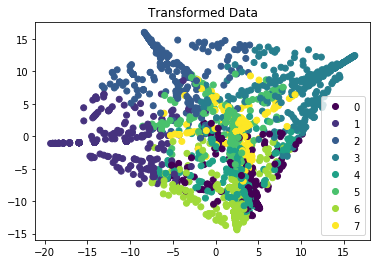

In [149]:
# Your code here

x = as_topics.fit(counts)
y = x.transform(counts)
plot_pca(y)

# Tweets Over Time

Now that we have an understanding of LDA, how the code works, and a way to evaluate it, we can look into ways to measure change in topics over time. We will look at tweets from February, March and April. These tweets were collected over a 6 day interval about 25 days apart. 

To observe change over time, you will perform LDA on a data set with all three months of tweets. Then, for each topic, we can look at the frequency of tweets from each month to see if some topics were more popular at different points in time. 

In [131]:
# Loading tweets
feb_tweets = pd.read_csv('feb_data.csv')
march_tweets = pd.read_csv('march_data.csv')
april_tweets = pd.read_csv('april_data.csv')

all_tweets = pd.concat([feb_tweets, march_tweets, april_tweets]).reset_index(drop=True)

## TASK 4: Perform LDA on  All Tweets

The variables that you will need after performing LDA for our visualization are:

```all_vectorizer``` - the vectorizer you create in order to get the counts for all the tweets

```all_counts``` - the ndarray of vectorized tweets

```all_as_topics``` - the trained LDA model. We used 20 topics but you can adjust the number as you see fit. 

Don't forget to create a new vectorizer and that you can use ```print_topics(as_topic, vectorizer)``` to print the topics


In [155]:
print(all_tweets.head())

   Unnamed: 0                 date  \
0           0  2020-02-19 23:59:11   
1           1  2020-02-19 23:59:00   
2           2  2020-02-19 23:56:52   
3           3  2020-02-19 23:55:34   
4           4  2020-02-19 23:53:03   

                                                text  
0  Head nurse Cai Liping of Wuchang Hospital died...  
1  This bacteria-killing UV light robot helps a W...  
2  For those that are into the business side of s...  
3        How to fight against #coronavirus in #japan  
4  Diseases like covid-19 are deadlier in non-dem...  


In [177]:
# Your code here

#all_tweets = pd.concat([feb_tweets, march_tweets, april_tweets]).reset_index(drop=True)

new_stops = text.ENGLISH_STOP_WORDS.union(
    
    ['COVID19', 'the', 'a', 'http', 'need', 'like', 'time', 'www', 
     'com', 'bit', 'ly', 'know','covid-19','everyday','deaths','cases',
     'thank','country', 'covid_19','coronavirus','amp','https',
     'covid','19','death','people', 'don', '2020','covid19', 'let','just', 
     'man','000', 'want', 'really', 'says','virus', 'corona', 'new', 'breaking',
     'doesn','ve','got','say','way','number','day','today','ago','ll','rs','reut',
     'test','tests','crisis', 'caused','case']

)

all_vectorizer = CountVectorizer(min_df= 5, stop_words=new_stops)

all_counts = all_vectorizer.fit_transform(all_tweets.text)

all_as_topics = LatentDirichletAllocation(n_components=8, random_state=0, n_jobs=6).fit(all_counts)

print_topics(all_as_topics, all_vectorizer)




['wuhan', 'china', 'chinese', 'world', 'outbreak', 'south', 'korea', 'confirmed', 'news', 'lockdown', 'read', 'italy']

['wuhan', 'china', 'japan', 'chinese', 'cruise', 'ship', 'quarantine', 'positive', 'passengers', 'days', 'diamond', 'princess']

['world', 'uk', 'government', 'stay', 'news', 'health', 'spread', 'doing', 'think', 'scientists', 'lives', 'save']

['fight', 'chinese', 'help', 'stay', 'health', 'social', 'staff', 'pandemic', 'medical', 'workers', 'support', 'safe']

['china', 'chinese', 'outbreak', 'media', 'economy', 'trump', 'amid', 'united', 'states', 'president', 'rate', 'drug']

['away', 'patients', 'care', 'response', 'health', 'spread', 'disease', 'trump', 'come', 'testing', 'home', 'person']

['china', 'outbreak', 'response', 'apple', 'pandemic', 'march', 'money', 'minister', 'production', 'corruption', 'paper', 'toilet']

['hospital', 'died', 'patients', 'twitter', 'white', 'pic', 'positive', 'trump', 'negative', 'house', 'tested', 'president']


Now we can visualize how topics have changed over time.

In [166]:
# Classify tweets into topics
tweet_dists = all_as_topics.transform(all_counts)
tweet_labels = np.argmax(tweet_dists, axis=1)
all_tweets = all_tweets.assign(tweet_labels= tweet_labels)

# Label tweets by month
months = pd.Series(["February"] * feb_tweets.shape[0] + ['March'] * march_tweets.shape[0] + ['April'] * april_tweets.shape[0])
all_tweets = all_tweets.assign(month=months)

# Get monthly counts for each topic
topic_counts = all_tweets.groupby(['tweet_labels','month']).count()
topic_counts.drop(['date','text'], axis=1, inplace=True)
topic_counts.columns =['monthly_count']

unstacked_topics = topic_counts.unstack()
unstacked_topics = unstacked_topics.monthly_count
unstacked_topics = unstacked_topics.reindex(columns=['February', 'March', 'April'])

unstacked_topics.head()

month,February,March,April
tweet_labels,,,
0,297,392,599
1,161,412,299
2,541,185,201
3,468,246,207
4,181,226,226


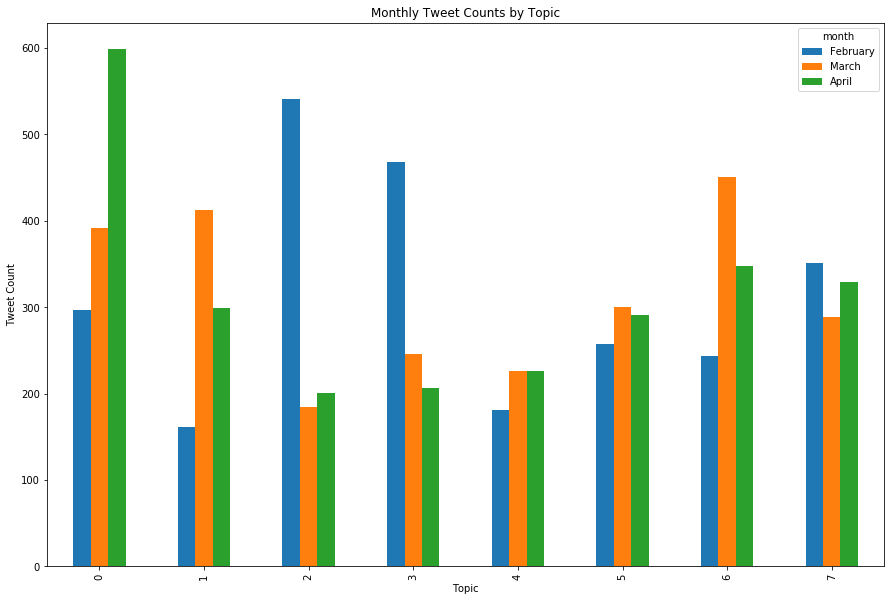

In [167]:
# Plot monthly counts for each topic
unstacked_topics.plot.bar(figsize=(15,10))
plt.title('Monthly Tweet Counts by Topic')
plt.xlabel('Topic')
plt.ylabel('Tweet Count')
plt.show()

## TASK 5: Discuss Results

Now it is time to do qualitative analysis of your topic modeling. You final task is to look at the graph above and choose a topic with a majority from each month and a topic that seems to be present in all months (4 total topics) and assign a semantic meaning to each based on the words associated with that topic (when you print the topics using print_topics() they are printed in the same order as the graph). For example if the words were ['test', 'positive', 'negative'...] you could say 'Testing for COVID-19'. Comment on whether the results on the bar graph make sense after assigning the semantic meaning to the topic. 

Topics 0, 5, 6, and 7 have appeared well over 200+ times per month from February to April.

Topic 0 may be related to how South Korea and Italy were the first countries to be impacted by coronavirus. Additionally, they were two of the first countries to undergo lockdown as a result of internal outbreak. (key words: Italy, South, Korea, lockdown, outbreak)

Although there doesn't appear to be any mention of "vaccines", I think that topic five concerns how crucial it is that people stay at home and be tested should they appear to be diagnosed with the disease. (Key words: spread, home, testing, disease)

Topic 6 could concern China's failure to communicate earlier on. (key words: China, corruption, pandemic)
It could also concern how the pandemic has scared many into overstocking on toilet paper. (Key words: toilet, paper)

Topic 7 may be about whether Trump and others in the White House have tested positive for COVID19 (Trump, positive, negative, tested, white, house)